In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_06 import *

# Get data

In [3]:
x_train,y_train,x_valid,y_valid= get_data_normalized()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [4]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
nh,bs,c

(50, 512, 10)

In [6]:
mnist_view = view_tfm(1,28,28) # 2d array to 3d imgs func
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [7]:
nfs = [8,16,32,64,64]
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
%time run.fit(2, learn)

train: [1.5024744791666667, tensor(0.5074, device='cuda:0')]
valid: [1.37926025390625, tensor(0.5565, device='cuda:0')]
train: [0.40002766927083333, tensor(0.8742, device='cuda:0')]
valid: [0.83749990234375, tensor(0.7451, device='cuda:0')]
CPU times: user 3.55 s, sys: 671 ms, total: 4.22 s
Wall time: 4.28 s


# Batchnorm

In [11]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        
        #declare trainable parameters for batchnorm
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # shape: (channels,1,1)
        self.adds  = nn.Parameter(torch.zeros(nf,1,1)) # this is identical to nn.Linear bias, thus we don't need to use bias when using batchnorm
        
        # exponentially moving avg variables
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) # use register_buffer to move anything in buffer to GPU
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x): # shape: (bs,channels,h,w)
        m = x.mean((0,2,3), keepdim=True) # shape: (1,channels,1,1)
        v = x.var ((0,2,3), keepdim=True)
        
        # keep an exponentially moving avg of x.mean and x.var IN TRAINING (not in inference)
        self.means.lerp_(m, self.mom) # aka linear interpolation
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: 
            #in inference time, we will just take the running mean and var so-far (WITHOUT UPDATING THEM)
            m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [12]:
# conv layer with batchnorm: nn.Sequential(conv2d -> generalRELU -> bn)
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [13]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

In [14]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

# Start training with bn

In [17]:
nfs

[8, 16, 32, 64, 64]

In [ ]:
??append_stats

In [19]:
learn,run = get_learn_run(nfs, data, 0.8, conv_layer, cbs=cbfs)

train: [0.422165234375, tensor(0.8676, device='cuda:0')]
valid: [1.0880578125, tensor(0.6932, device='cuda:0')]
train: [0.17113434244791667, tensor(0.9469, device='cuda:0')]
valid: [0.621439599609375, tensor(0.8136, device='cuda:0')]


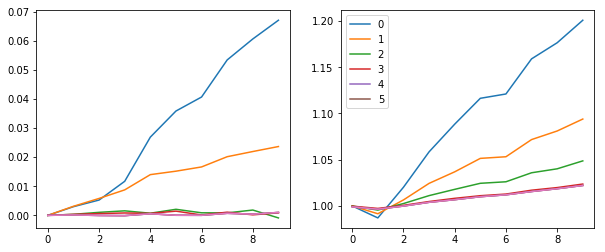

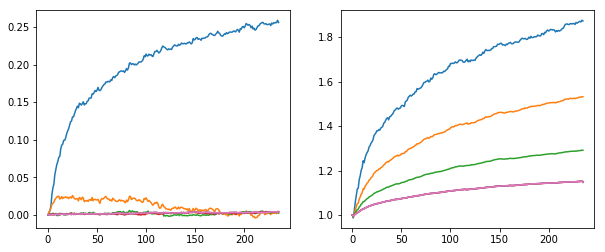

In [20]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

Previous training with kaiming init and general RELU

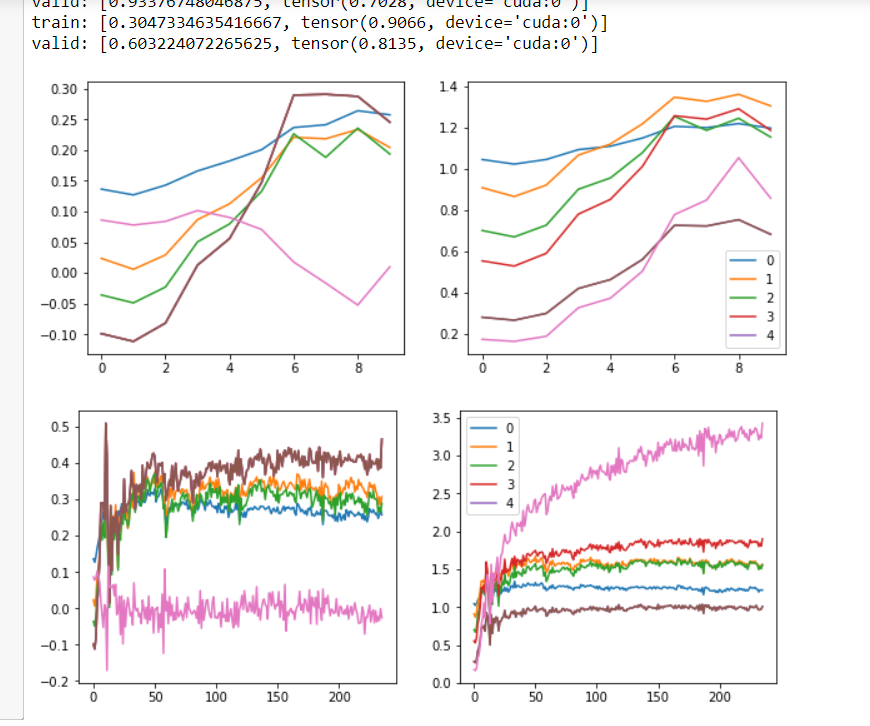

Activations mean and std are closer to 0 and 1, respectively. There is no 'jump' in mean and std for long training

We can now train with high lr and still have good results (probably due to bn smoothens the loss landscape)

In [22]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)
%time run.fit(3, learn)

train: [0.40569283854166666, tensor(0.8728, device='cuda:0')]
valid: [0.59304794921875, tensor(0.8172, device='cuda:0')]
train: [0.162238134765625, tensor(0.9494, device='cuda:0')]
valid: [0.84671328125, tensor(0.7612, device='cuda:0')]
train: [0.11929239095052083, tensor(0.9633, device='cuda:0')]
valid: [0.355112158203125, tensor(0.8917, device='cuda:0')]
CPU times: user 3.35 s, sys: 410 ms, total: 3.76 s
Wall time: 3.76 s


# Using pytorch batchnorm

In [23]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [24]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [25]:
%time run.fit(3, learn)

train: [0.44440302734375, tensor(0.8620, device='cuda:0')]
valid: [0.54625595703125, tensor(0.8251, device='cuda:0')]
train: [0.16365787760416667, tensor(0.9493, device='cuda:0')]
valid: [0.46501845703125, tensor(0.8618, device='cuda:0')]
train: [0.11008968912760417, tensor(0.9662, device='cuda:0')]
valid: [0.34687939453125, tensor(0.8997, device='cuda:0')]
CPU times: user 3.24 s, sys: 328 ms, total: 3.57 s
Wall time: 3.57 s


# Full training with bn

In [26]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [27]:
run.fit(8, learn)

train: [0.47966953125, tensor(0.8549, device='cuda:0')]
valid: [1.3887669921875, tensor(0.6751, device='cuda:0')]
train: [0.16263758138020834, tensor(0.9506, device='cuda:0')]
valid: [1.42736259765625, tensor(0.6497, device='cuda:0')]
train: [0.11685853678385416, tensor(0.9641, device='cuda:0')]
valid: [0.652740673828125, tensor(0.8236, device='cuda:0')]
train: [0.06810780843098958, tensor(0.9790, device='cuda:0')]
valid: [0.403175048828125, tensor(0.8863, device='cuda:0')]
train: [0.04309617513020833, tensor(0.9865, device='cuda:0')]
valid: [0.2615804443359375, tensor(0.9303, device='cuda:0')]
train: [0.028717683919270834, tensor(0.9915, device='cuda:0')]
valid: [0.3019836181640625, tensor(0.9217, device='cuda:0')]
train: [0.018538741048177085, tensor(0.9954, device='cuda:0')]
valid: [0.2493968017578125, tensor(0.9373, device='cuda:0')]
train: [0.012265238444010416, tensor(0.9977, device='cuda:0')]
valid: [0.232669189453125, tensor(0.9439, device='cuda:0')]


## Problem with batchnorm

In [36]:
torch.Tensor([2]).mean(),torch.Tensor([2]).var()

(tensor(2.), tensor(nan))

In [37]:
torch.Tensor([2.01,2.02]).mean(),torch.Tensor([2.01,2.02]).var()

(tensor(2.0150), tensor(5.0000e-05))

### 1. Cannot apply model with bn to 'online learning task' where the batch size has to be small (only 1 or 2 items can be fed at a time)

Var of batch with 1 item is 0. For 2 items,  it would be very small if these 2 images are similar 

-> x_updated = x-mean/(sqrt(var+ep)) will be huge -> mess up our training


### 2. Also batchnorm cannot be used for RNN when we reuse our weight matrices for learning in order to have predict n words-> we can't just put a batchnorm at each activation (for each word) since there could be thousand of these activations (e.g. when predicting next words)

### 3. When calculating mean and std of a batch in batchnorm, we assume that item in batch has the same size (e.g. img with same h,w,channels). In RNN, sentences in a batch can have different length (Although this can be fixed with padding, but by adding padding, it can alter the true meaning of mean and std of that batch)

# Different norm strategy

## layer norm

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

Layer norm formula is essentially the same as batchnorm, but
- No moving average
- Average over the hidden dimension to make the norm strategy **independent of the batch size**

Previous batchnorm code

```python
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # shape: (channels,1,1)
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))        
        # exponentially moving avg variables
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) 
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x): # shape: (bs,channels,h,w)
        m = x.mean((0,2,3), keepdim=True) # shape: (1,channels,1,1)
        v = x.var ((0,2,3), keepdim=True)        
        # keep an exponentially moving avg of x.mean and x.var IN TRAINING (not in inference)
        self.means.lerp_(m, self.mom) # aka linear interpolation
        self.vars.lerp_ (v, self.mom)
        return m,v        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds
```

In [40]:
torch.randn((5,3,2,2)).mean((1,2,3), keepdim=True).shape

torch.Size([5, 1, 1, 1])

In [42]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        # We don't use exp moving avg here because each img now has its own mean and std. Each img can take care of itself 
        # In batchnorm, mean and std are calculated **across a batch** containing multiple imgs, thus we need exp moving avg
        # to smoothen them out
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True) # shape: (bs,1,1,1). Taking the mean of each image in batch individually
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

## Downside of layer norm

There is no running avg at inference time (note that running avg represents the mean and std of a whole dataset).

There is no different normalization at each channel



In [47]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [52]:
# cannot train well with high learning rate however!
learn,run = get_learn_run(nfs, data, 0.4, conv_ln, cbs=cbfs)

In [53]:
%time run.fit(3, learn)

train: [0.5382471028645833, tensor(0.8295, device='cuda:0')]
valid: [0.63941650390625, tensor(0.8101, device='cuda:0')]
train: [0.181573876953125, tensor(0.9451, device='cuda:0')]
valid: [0.523219384765625, tensor(0.8532, device='cuda:0')]
train: [0.12032320963541666, tensor(0.9630, device='cuda:0')]
valid: [0.37282265625, tensor(0.8989, device='cuda:0')]
CPU times: user 3.93 s, sys: 420 ms, total: 4.35 s
Wall time: 4.36 s


In [56]:
# cannot train well with high learning rate however!
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

%time run.fit(3, learn)

train: [0.5171153971354167, tensor(0.8355, device='cuda:0')]
valid: [0.64896796875, tensor(0.8131, device='cuda:0')]
train: [0.14763146158854168, tensor(0.9549, device='cuda:0')]
valid: [0.71297275390625, tensor(0.8128, device='cuda:0')]
train: [0.0957650146484375, tensor(0.9706, device='cuda:0')]
valid: [0.537066552734375, tensor(0.8582, device='cuda:0')]
CPU times: user 3.95 s, sys: 379 ms, total: 4.33 s
Wall time: 4.34 s


One example that would make layernorm model fail to train: sunny day vs foggy day (where variances are very different from each other). However when you normalize them individually, they will turn out to be similar. (Insert img proof here) By normalizing individually, you throw away the difference in the activation (the pixels in this case)

